# <span style="color:#0b486b">  FIT3181: Deep Learning (2022)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **[Wen]**  <br/>
Firstname: **[Wen]**    <br/>
Student ID: **[31514081]**    <br/>
Email: **[wwen0009@student.monash.edu]**    <br/>
Your tutorial time: **[FIT3181 Laboratory 01_OnCampus: Thursday 10:00-12:00]**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 23 October 2022</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **five** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on Text CNN for sequence modeling and neural embedding **[10 points]**
* Part 4: Coding assessment on BERT for a feature extraction **[10 points]**
* Part 5: Coding assessment on RNNs for sequence modeling and neural embedding **[55 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 7 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [2]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)
import warnings  # In order not to show warning
warnings.filterwarnings("ignore")

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment. 

In [15]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [16]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [17]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

The function of DataManager is to divide all the data into 80% for training and 20% for validation.
The structure of the training data and the validation data is the same.

str_questions is a variable that is converted to a string type for each question in the file
train_str_questions means that it is a question in the training data set.

numeral_label is the label corresponding to each question, there are 6 labels in total.
train_numerical_label means it is a label in the training dataset expressed using numeric forms

#Your answer here




In [5]:
#Your code here
for i in range(5):
    print(dm.train_str_questions[i])
    print(dm.train_numeral_labels[i])

manner how did serfdom develop in and then leave russia ?
1
cremat what films featured the character popeye doyle ?
2
manner how can i find a list of celebrities ' real names ?
1
animal what fowl grabs the spotlight after the chinese year of the monkey ?
2
exp what is the full form of .com ?
0


#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

train_numeral_data is the data of train_str_questions after numerical conversion, because neural network model cannot receive string type as input




In [6]:
for i in range(5):
    print(dm.train_numeral_data[i])

[  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

In the previous step, we converted all questions into numeric form, separating the words in each sentence one by one

The use of word2idx is to keep the information of index, stored as [word,1]

idx2word is stored in the opposite way to word2idx, in the way [1,word]

This will make the subsequent code run with less complexity and faster processing time

In [7]:
#Your code here
word2idx = list(dm.word2idx.items())
idx2word = list(dm.idx2word.items())
for i in range (5):
    print(word2idx[i])
    print(idx2word[i])

('the', 1)
(1, 'the')
('what', 2)
(2, 'what')
('is', 3)
(3, 'is')
('of', 4)
(4, 'of')
('in', 5)
(5, 'in')


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

tf_train_set is the data stitched together from_tensor_slices() with train_numeral_data, train_numeral_labels

The model is used to train a neural network model that can identify the type of problem


In [8]:
#Your code here
for i in range (5):
    print(next(iter(dm.tf_train_set)))

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  35,   11,   18, 1030, 1031,    5,   25,  561, 1032,  562,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  35,   11,   18, 1030, 1031,    5,   25,  561, 1032,  562,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

tf_valid_set is the data stitched together from_tensor_slices() from valid_numeral_data, valid_numeral_labels

This model is the neural network model used in the validation process

In [9]:
#Your code here
for i in range (5):
    print(next(iter(dm.tf_valid_set)))

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  23,    2,   23,   13,  243,    3,   53,    1, 3031,   20,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  23,    2,   23,   13,  243,    3,   53,    1, 3031,   20,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [10]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [18]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [19]:
word2vect = api.load("glove-wiki-gigaword-100")

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [20]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)#Insert your code here
    except: #word not in the vocabulary
        vector = np.zeros(100)#Insert your code here
    return vector

#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [21]:
def get_sentence_vector(sentence, important_score=None, model= None):
    if important_score == None:
        softmax_val = np.ones(len(sentence))
        important_weight = np.exp(softmax_val)/np.sum(np.exp(softmax_val),axis = 0)
        
    else:
        softmax_val = np.array(important_score)
        important_weight = np.exp(softmax_val)/np.sum(np.exp(softmax_val),axis = 0)
    
    vector = np.zeros(100)
    for i in range(len(sentence)):
        vector += important_weight[i] * get_word_vector(sentence[i],model)
        
    return vector
    

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [22]:
print("Transform training set to feature vectors...")
X_train = []
for question in dm.train_str_questions:
    sentence = question.split(" ")
    length = len(sentence)
    important_score = [0.9**i for i in range(length)]
    X_train.append(get_sentence_vector(sentence,important_score,word2vect))
X_train= np.array(X_train)
y_train= dm.train_numeral_labels

Transform training set to feature vectors...


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [23]:
print("Transform valid set to feature vectors...")
X_valid = []
for question in dm.valid_str_questions:
    sentence = question.split(" ")
    length = len(sentence)
    important_score = [0.9**i for i in range(length)]
    X_valid.append(get_sentence_vector(sentence,important_score,word2vect))
X_valid= np.array(X_valid)
y_valid= dm.valid_numeral_labels

Transform valid set to feature vectors...


#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [24]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [19]:
# #SVC(
#     *,
#     C=1.0,
#     kernel='rbf',
#     degree=3,
#     gamma='scale',
#     coef0=0.0,
#     shrinking=True,
#     probability=False,
#     tol=0.001,
#     cache_size=200,
#     class_weight=None,
#     verbose=False,
#     max_iter=-1,
#     decision_function_shape='ovr',
#     break_ties=False,
#     random_state=None,
# )

In [20]:
svm = SVC(C=1.0,kernel='rbf',gamma=2**(-3))
svm.fit(X_train,y_train)

SVC(gamma=0.125)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [21]:
y_valid_pred= svm.predict(X_valid)
result = np.equal(y_valid_pred, y_valid)
num_True_len = []
for i in result:
    if i == True:
        num_True_len.append(i)
# print(num_True_len)
num_True = len(num_True_len)

acc = num_True/result.shape[0]#Insert your code

print(acc)

0.9565217391304348


## <span style="color:#0b486b">Part 3: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 3.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times vocab\_size \times embed\_size]$ as $h$.
  - We feed $h$ to three Convd 1D layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 points]</span></div>
  

In [22]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size)(x)
        h1 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=3, activation='relu', padding="same")(h)#Insert your code here
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=5, activation='relu', padding="same")(h)#Insert your code here
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=7, activation='relu', padding="same")(h)#Insert your code here
        h1 = tf.keras.layers.GlobalMaxPool1D()(h1)#Insert your code here
        h2 = tf.keras.layers.GlobalMaxPool1D()(h2)#Insert your code here
        h3 = tf.keras.layers.GlobalMaxPool1D()(h3)#Insert your code here
        h = tf.keras.layers.Concatenate(axis=-1)([h1, h2, h3])#Insert your code here
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach SVM + Word2Vect for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [23]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()
#Insert code here to compile the model
text_cnn.compile_model(loss="sparse_categorical_crossentropy",optimizer="adam", metrics=['accuracy'])
text_cnn.model.summary()
#Insert code here to train the model on 20 epochs
text_cnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    428160      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     6160        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     10256       embedding[0][0]                  
_______________________________________________________________________________________

## <span style="color:#0b486b">Part 4: Sentence representation with BERT </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[6 points]</span></div>

#Insert your code for extracting training set
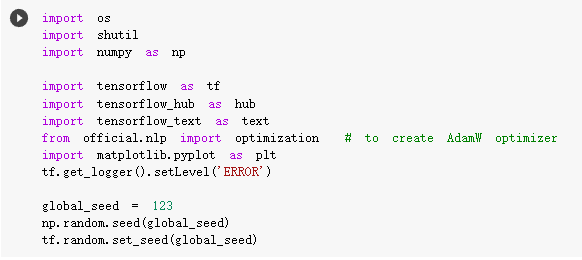
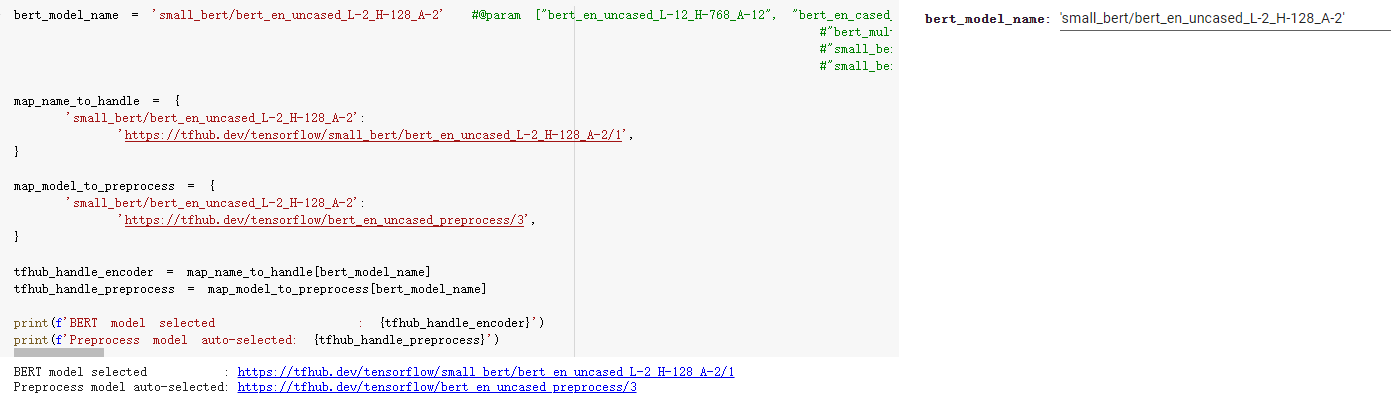
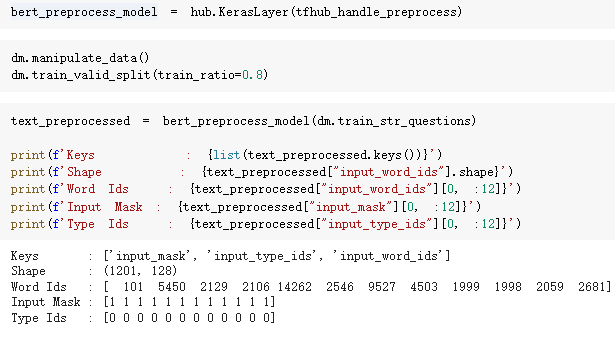
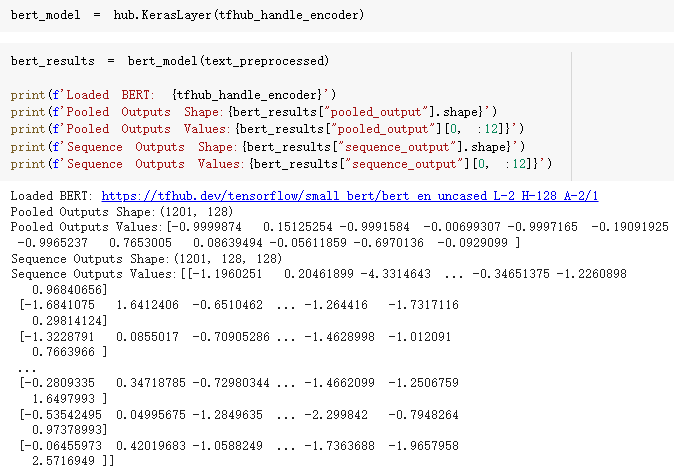

#### <span style="color:red">**Question 4.2**</span>
**Use Logistic Regression to train on the training set and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [27]:
#Insert your code for training here
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [28]:
#Insert your code for testing here
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_valid, y_valid)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [38]:
for i in range(5):
    print('Predicted value is:', lm.predict([X_valid[i]]))
print ('Accuracy is:',lm.score(X_valid, y_valid))

Predicted value is: [4]
Predicted value is: [3]
Predicted value is: [2]
Predicted value is: [5]
Predicted value is: [4]
Accuracy is: 0.9899665551839465


## <span style="color:#0b486b">Part 5: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 55 points]<span></div>

### <span style="color:#0b486b">5.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 5.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [28]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(state_size, return_sequences = return_sequences, activation = activation)#Insert your code here
        if cell_type== 'lstm':
            return tf.keras.layers.LSTM(state_size, return_sequences = return_sequences, activation = activation)#Insert your code here
        else:
            return tf.keras.layers.SimpleRNN(state_size, return_sequences = return_sequences, activation = activation)#Insert your code here
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)#Insert your code here
        num_layers = len(self.state_sizes) + 1#Insert your code here
        for i in range(num_layers):
            if i == 0:
                h =  self.get_layer(cell_type = self.cell_type, state_size = self.embed_size, return_sequences= True)(h)#Insert your code here, you can insert more lines if necessary
            if i == len(self.state_sizes):
                h = self.get_layer(cell_type = self.cell_type, state_size = self.state_sizes[i-1], return_sequences= False)(h)
            else:
                h = self.get_layer(cell_type = self.cell_type, state_size = self.state_sizes[i-1], return_sequences= True)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [29]:
uni_rnn = UniRNN(cell_type = "basic_rnn",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 2s 105ms/step - loss: 1.0393 - accuracy: 0.6203 - val_loss: 0.4308 - val_accuracy: 0.8829
Epoch 2/20
19/19 [==============================] - 2s 91ms/step - loss: 0.2887 - accuracy: 0.9176 - val_loss: 0.6169 - val_accuracy: 0.7893
Epoch 3/20
19/19 [==============================] - 2s 95ms/step - loss: 0.1843 - accuracy: 0.9484 - val_loss: 0.2860 - val_accuracy: 0.9231
Epoch 4/20
19/19 [==============================] - 2s 93ms/step - loss: 0.1169 - accuracy: 0.9667 - val_loss: 0.2863 - val_accuracy: 0.8997
Epoch 5/20
19/19 [==============================] - 2s 83ms/step - loss: 0.0443 - accuracy: 0.9875 - val_loss: 0.1403 - val_accuracy: 0.9465
Epoch 6/20
19/19 [==============================] - 2s 83ms/step - loss: 0.0295 - accuracy: 0.9942 - val_loss: 0.1660 - val_accuracy: 0.9532
Epoch 7/20
19/19 [==============================] - 2s 82ms/step - loss: 0.2312 - accuracy: 0.9376 - val_loss: 0.1383 - val_accuracy: 0.9398
Epoch 8/20
1

#### <span style="color:red">**Question 5.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [30]:
uni_rnn = UniRNN(cell_type = "gru",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 8s 423ms/step - loss: 1.3793 - accuracy: 0.4172 - val_loss: 0.7471 - val_accuracy: 0.7224
Epoch 2/20
19/19 [==============================] - 4s 231ms/step - loss: 0.4719 - accuracy: 0.8560 - val_loss: 0.3269 - val_accuracy: 0.8963
Epoch 3/20
19/19 [==============================] - 4s 237ms/step - loss: 0.1729 - accuracy: 0.9450 - val_loss: 0.2646 - val_accuracy: 0.9130
Epoch 4/20
19/19 [==============================] - 5s 252ms/step - loss: 0.0882 - accuracy: 0.9784 - val_loss: 0.2630 - val_accuracy: 0.9331
Epoch 5/20
19/19 [==============================] - 5s 237ms/step - loss: 0.0580 - accuracy: 0.9800 - val_loss: 0.2383 - val_accuracy: 0.9231
Epoch 6/20
19/19 [==============================] - 5s 251ms/step - loss: 0.0171 - accuracy: 0.9958 - val_loss: 0.1099 - val_accuracy: 0.9632
Epoch 7/20
19/19 [==============================] - 5s 266ms/step - loss: 0.0737 - accuracy: 0.9784 - val_loss: 0.0964 - val_accuracy: 0.9732
Epoch 

#### <span style="color:red">**Question 5.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [31]:
uni_rnn = UniRNN(cell_type = "lstm",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 8s 403ms/step - loss: 1.3938 - accuracy: 0.4530 - val_loss: 0.9544 - val_accuracy: 0.8395
Epoch 2/20
19/19 [==============================] - 6s 310ms/step - loss: 0.5228 - accuracy: 0.8634 - val_loss: 0.4009 - val_accuracy: 0.9331
Epoch 3/20
19/19 [==============================] - 6s 300ms/step - loss: 0.2004 - accuracy: 0.9567 - val_loss: 0.2606 - val_accuracy: 0.9532
Epoch 4/20
19/19 [==============================] - 6s 301ms/step - loss: 0.1587 - accuracy: 0.9659 - val_loss: 0.1833 - val_accuracy: 0.9565
Epoch 5/20
19/19 [==============================] - 6s 328ms/step - loss: 0.0887 - accuracy: 0.9784 - val_loss: 0.3056 - val_accuracy: 0.9130
Epoch 6/20
19/19 [==============================] - 6s 311ms/step - loss: 0.0767 - accuracy: 0.9784 - val_loss: 0.1543 - val_accuracy: 0.9431
Epoch 7/20
19/19 [==============================] - 6s 296ms/step - loss: 0.0369 - accuracy: 0.9900 - val_loss: 0.1593 - val_accuracy: 0.9565
Epoch 

### <span style="color:#0b486b">5.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 5.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [32]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1
        
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences = return_sequences)) #Insert your code here
        elif cell_type== 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences = return_sequences)) #Insert your code here
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences = return_sequences)) #Insert your code here
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)#Insert your code here
        num_layers = len(self.state_sizes) + 1#Insert your code here
        for i in range(num_layers):
            if i == 0:
                h = self.get_layer(cell_type = self.cell_type, state_size = self.embed_size, return_sequences= True)(h) #Insert your code here, you can insert more lines if necessary
            if i == len(self.state_sizes):
                h = self.get_layer(cell_type = self.cell_type, state_size = self.state_sizes[i - 1], return_sequences= False)(h)
            else:
                h = self.get_layer(cell_type = self.cell_type, state_size = self.state_sizes[i - 1], return_sequences= True)(h)

        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [33]:
bi_rnn = BiRNN(cell_type = "basic_rnn",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 6s 291ms/step - loss: 0.6534 - accuracy: 0.7744 - val_loss: 0.2524 - val_accuracy: 0.9298
Epoch 2/20
19/19 [==============================] - 4s 206ms/step - loss: 0.0697 - accuracy: 0.9775 - val_loss: 0.2077 - val_accuracy: 0.9331
Epoch 3/20
19/19 [==============================] - 4s 218ms/step - loss: 0.0099 - accuracy: 0.9992 - val_loss: 0.1212 - val_accuracy: 0.9498
Epoch 4/20
19/19 [==============================] - 4s 202ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1239 - val_accuracy: 0.9498
Epoch 5/20
19/19 [==============================] - 4s 205ms/step - loss: 5.6077e-04 - accuracy: 1.0000 - val_loss: 0.1269 - val_accuracy: 0.9565
Epoch 6/20
19/19 [==============================] - 4s 205ms/step - loss: 2.0988e-04 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9532
Epoch 7/20
19/19 [==============================] - 4s 209ms/step - loss: 7.7188e-05 - accuracy: 1.0000 - val_loss: 0.1391 - val_accuracy: 0

#### <span style="color:red">**Question 5.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [34]:
bi_rnn = BiRNN(cell_type = "gru",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 18s 953ms/step - loss: 1.0993 - accuracy: 0.5745 - val_loss: 0.6613 - val_accuracy: 0.7826
Epoch 2/20
19/19 [==============================] - 13s 663ms/step - loss: 0.2195 - accuracy: 0.9251 - val_loss: 0.2459 - val_accuracy: 0.9064
Epoch 3/20
19/19 [==============================] - 13s 668ms/step - loss: 0.0474 - accuracy: 0.9825 - val_loss: 0.3232 - val_accuracy: 0.9264
Epoch 4/20
19/19 [==============================] - 13s 664ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.1664 - val_accuracy: 0.9465
Epoch 5/20
19/19 [==============================] - 13s 665ms/step - loss: 0.1122 - accuracy: 0.9725 - val_loss: 0.1466 - val_accuracy: 0.9699
Epoch 6/20
19/19 [==============================] - 13s 658ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1144 - val_accuracy: 0.9632
Epoch 7/20
19/19 [==============================] - 13s 661ms/step - loss: 4.9064e-04 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0.

#### <span style="color:red">**Question 5.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [35]:
bi_rnn = BiRNN(cell_type = "lstm",embed_size = 128, state_sizes = [64, 128],data_manager = dm)#Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 23s 1s/step - loss: 1.3438 - accuracy: 0.5071 - val_loss: 0.6113 - val_accuracy: 0.8462
Epoch 2/20
19/19 [==============================] - 21s 1s/step - loss: 0.4754 - accuracy: 0.8659 - val_loss: 0.3103 - val_accuracy: 0.9164
Epoch 3/20
19/19 [==============================] - 21s 1s/step - loss: 0.2383 - accuracy: 0.9342 - val_loss: 0.2052 - val_accuracy: 0.9264
Epoch 4/20
19/19 [==============================] - 21s 1s/step - loss: 0.0625 - accuracy: 0.9875 - val_loss: 0.1830 - val_accuracy: 0.9398
Epoch 5/20
19/19 [==============================] - 21s 1s/step - loss: 0.1662 - accuracy: 0.9609 - val_loss: 0.1761 - val_accuracy: 0.9498
Epoch 6/20
19/19 [==============================] - 21s 1s/step - loss: 0.0291 - accuracy: 0.9950 - val_loss: 0.2324 - val_accuracy: 0.9465
Epoch 7/20
19/19 [==============================] - 21s 1s/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.1773 - val_accuracy: 0.9565
Epoch 8/20
19/19 [==

### <span style="color:#0b486b">5.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 11 points]<span></div>

#### <span style="color:red">**Question 5.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [1]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idex in self.word2idx.items():
            try:
                self.embed_matrix[idex] = self.word2vect.word_vec(word)
            except KeyError:
                pass
        #Insert your code here
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        
        if network_type == "uni-directional":
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size, return_sequences = return_sequences)
            if cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size, return_sequences = return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size, return_sequences = return_sequences)
        if network_type == "bi-directional":
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hidden_size, activation = activation, return_sequences = return_sequences))
            if cell_type== 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, activation = activation, return_sequences = return_sequences))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, activation = activation, return_sequences = return_sequences))
        
        #Insert your code here
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        if self.run_mode == "init-only":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, weights= [self.embed_matrix], trainable= False)(x)
        if self.run_mode == "init-fine-tune":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, weights= [self.embed_matrix], trainable= True)(x)
        num_layers = len(self.state_sizes) + 1 #Insert your code here
        for i in range(num_layers):
            # for the first layer
            if i == 0:
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.embed_size, return_sequences= True)(h)
            # for the last layer
            if i == len(self.state_sizes):
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.state_sizes[i - 1], return_sequences= False)(h)
            else:
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.state_sizes[i - 1], return_sequences= True)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        #Insert your code here
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [17]:
modes = ["scratch", "init-only", "init-fine-tune"]
for mode in modes:
    print(f"Current mode is {mode}")
    my_rnn = RNN(run_mode = mode, cell_type = "lstm", network_type = 'bi-directional', data_manager = dm, embed_size = 128, state_sizes = [64, 128])
    my_rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    my_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    my_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64), verbose = False)
    my_rnn.evaluate(dm.tf_valid_set.batch(64))

Current mode is scratch
5/5 [==============================] - 8s 2s/step - loss: 0.6931 - accuracy: 0.9465
Current mode is init-only
5/5 [==============================] - 7s 1s/step - loss: 0.1686 - accuracy: 0.9632
Current mode is init-fine-tune
5/5 [==============================] - 7s 1s/step - loss: 0.4809 - accuracy: 0.9632


The best model is init-only and init-fine-tune which has accuracy 96.32%, then the mode scratch with accuracy 94.65%.

#### <span style="color:red">**Question 5.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

#Report your results here

Model 1 (run_mode ='init-fine-tune',...): accuracy = ...

......................................................

In [38]:
state_sizes = [[32, 32], [32, 128], [128, 32], [32, 64], [64, 32]]
for i in range (len(state_sizes)):
    print("Model " + str(i+1) + ": (run_mode = init-fine-tune, cell_type = gru, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = " + str(state_sizes[i]) + ")")
    my_rnn = RNN(run_mode = 'init-fine-tune', cell_type = "lstm", network_type = 'bi-directional', data_manager = dm, embed_size = 128, state_sizes = state_sizes[i])
    my_rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    my_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    my_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64), verbose = False)
    my_rnn.evaluate(dm.tf_valid_set.batch(64))
    print(i)

Model 1: (run_mode = init-fine-tune, cell_type = gru, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [32, 32])
5/5 [==============================] - 1s 134ms/step - loss: 0.2491 - accuracy: 0.9632
0
Model 2: (run_mode = init-fine-tune, cell_type = gru, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [32, 128])
5/5 [==============================] - 2s 360ms/step - loss: 0.2941 - accuracy: 0.9632
1
Model 3: (run_mode = init-fine-tune, cell_type = gru, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [128, 32])
5/5 [==============================] - 1s 239ms/step - loss: 1.2733 - accuracy: 0.8662
2
Model 4: (run_mode = init-fine-tune, cell_type = gru, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [32, 64])
5/5 [==============================] - 1s 227ms/step - loss: 0.2830 - accuracy: 0.9699
3
Model 5: (run_mode = init-fine-tune, cell_type = gru, netw

My best model is Model 4

In [18]:
my_best_rnn = RNN(run_mode = 'init-fine-tune', cell_type = "lstm", network_type = 'bi-directional', data_manager = dm, embed_size = 128, state_sizes = [32, 64])
my_best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64), verbose = False)
my_best_rnn.evaluate(dm.tf_valid_set.batch(64))

5/5 [==============================] - 4s 810ms/step - loss: 0.2972 - accuracy: 0.9666


### <span style="color:#0b486b">5.4. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 14 points]<span></div>

#### <span style="color:red">**Question 5.4.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [8]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyAttention, self).__init__()
        self.M = tf.keras.layers.Dense(output_length)
        self.N = tf.keras.layers.Dense(1)
        #Inser your code here
    
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        #Insert your code here
        # compute score [batch_size, num_timesteps, 1]
        attention_score = self.N(tf.keras.activations.tanh(self.M(all_states)))
        # compute weight [batch_size, num_timesteps, 1]
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        # compute context [batch_size, decoder_dim]
        context = attention_weight*all_states
        context = tf.reduce_sum(context, axis=1)
        context = tf.concat([context,last_state],axis = 1)
                                 
        return context

#### <span style="color:red">**Question 5.4.2**</span> 

**You are required to extend the class `RNN` in Section `5.3.1` to achieve the class `Attention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [10]:
class Attention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word)
            except KeyError:
                pass
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        
        #Insert your code here
        if network_type == "uni-directional":
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size, return_sequences = return_sequences)
            if cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size, return_sequences = return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size, return_sequences = return_sequences)
        if network_type == "bi-directional":
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hidden_size, activation = activation, return_sequences = return_sequences))
            if cell_type== 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, activation = activation, return_sequences = return_sequences))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, activation = activation, return_sequences = return_sequences))
        
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        if self.run_mode == "init-only":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, weights= [self.embed_matrix], trainable= False)(x)
        if self.run_mode == "init-fine-tune":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, weights= [self.embed_matrix], trainable= True)(x)
        num_layers = len(self.state_sizes)+1  #Insert your code here
        for i in range(num_layers):
            # for the first layer
            if i == 0:
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.embed_size, return_sequences= True)(h)
            # for the last layer
            if i == num_layers-1:
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.state_sizes[i - 1], return_sequences= True)(h)
            else:
                h = self.get_layer(cell_type = self.cell_type, network_type= self.network_type, hidden_size = self.state_sizes[i - 1], return_sequences= True)(h)
        
        attention = MyAttention()
        h = attention(h,h[:,-1,:])
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
        
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.4.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [12]:
state_sizes = [[64, 64], [32, 128], [128, 32], [32, 64], [64, 32]]
network_types = ['bi-directional','uni-directional']
cell_types = ['lstm','gru','basic_rnn']
count = 1
for i in range (len(state_sizes)):  
    for network_type in network_types:
        for cell_type in cell_types:
            print(f"Model {count} : cell_type ={cell_type},network_type = {network_type}, data_manager = dm, embed_size = 128, state_sizes = {str(state_sizes[i])})")
#                 print("Model " + str(i+1) + ": (run_mode = init-fine-tune, cell_type = lstm, network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = " + str(state_sizes[i]) + ")")
            my_rnn = Attention_RNN(cell_type = cell_type, network_type = network_type, data_manager = dm, embed_size = 128, state_sizes = state_sizes[i])
            my_rnn.build()
            opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
            my_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            my_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64), verbose = False)
            my_rnn.evaluate(dm.tf_valid_set.batch(64))
            count  = count + 1 

   

Model 1 : cell_type =lstm,network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [64, 64])
5/5 [==============================] - 4s 723ms/step - loss: 0.5216 - accuracy: 0.9498
Model 2 : cell_type =gru,network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [64, 64])
5/5 [==============================] - 3s 581ms/step - loss: 0.6108 - accuracy: 0.9565
Model 3 : cell_type =basic_rnn,network_type = bi-directional, data_manager = dm, embed_size = 128, state_sizes = [64, 64])
5/5 [==============================] - 1s 244ms/step - loss: 0.1842 - accuracy: 0.9699
Model 4 : cell_type =lstm,network_type = uni-directional, data_manager = dm, embed_size = 128, state_sizes = [64, 64])
5/5 [==============================] - 2s 336ms/step - loss: 0.2034 - accuracy: 0.9365
Model 5 : cell_type =gru,network_type = uni-directional, data_manager = dm, embed_size = 128, state_sizes = [64, 64])
5/5 [==============================] - 1s 242ms/step - lo

### <span style="color:#0b486b">5.5. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [22]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 5.5.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [23]:
def find_most_similar(word= None, k=5, model= None):
    try:
        #Insert your code here
        idx_word = dm.word2idx[word]
        embed_matrix = model.embed_matrix
        embedding_word = embed_matrix[idx_word]
        temp=[]
            for i in range(len(embed_matrix)):
        temp = [(i,embed_matrix[i])]
        temp = sorted(temp,key = lambda i: cosine_similarity(embedding_word,i[1]), reverse = True)
        output=[]
            for i in temp[1:k+1]:
        output = [dm.idx2word[i[0]]]
        return output
    except: #word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [24]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

['russia',
 'italy',
 'soviet',
 'canada',
 'berlin',
 'france',
 'japan',
 'countries',
 'brazil',
 'vietnam']

#### <span style="color:red">**Question 5.5.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word= None, model= None, k= 10):
   #Insert yout codeh here
    word_list = find_most_similar(word = word, model= model, k = k)
    index = [dm.word2idx[i] for i in word_list]

    embed_matrix = model.embed_matrix
    embedding = [embed_matrix[i] for i in index]
    low_dim_embs = tsne.fit_transform(embedding)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(word_list):
        x,y,z =  low_dim_embs[i,:]
        ax.scatter(x, y, z)
        ax.text(x, y, z, label)
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()

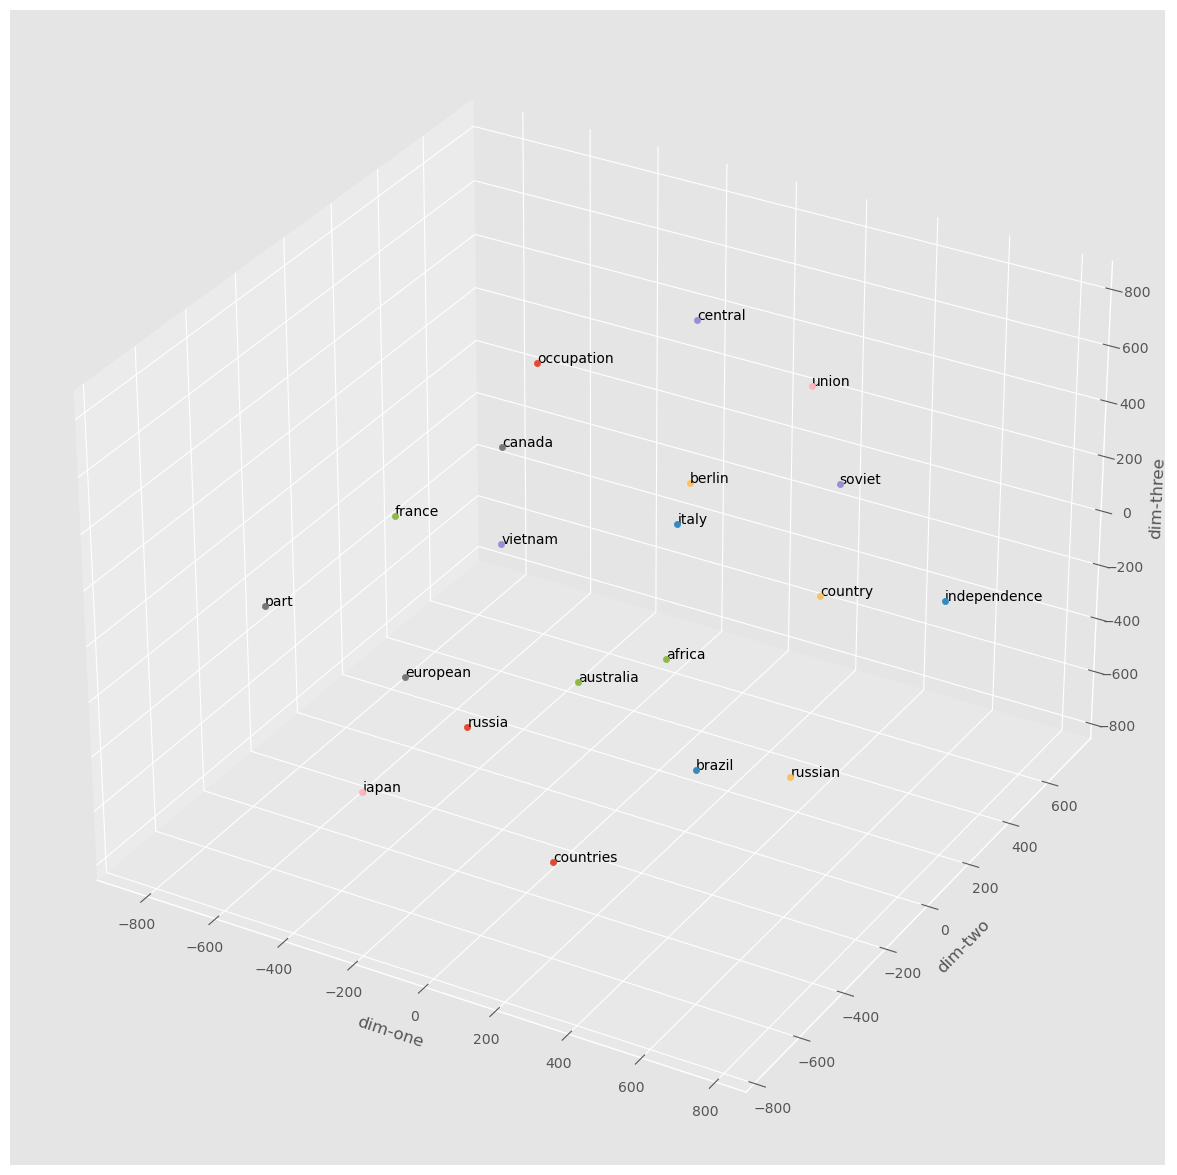

In [28]:
plot3D_with_labels(word='poland', k=20, model= my_best_rnn)


--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>